In [1]:
%matplotlib inline

# Imports

In [2]:
from holoinfer.model import hologram, math

import numpy as np

import matplotlib.pyplot as plt

import emcee

from lmfit import minimize, Parameters

import functools

# New Functions

## Holograms:

Original theano-freindly version:

In [ ]:
def dist(*vec):
    return np.sqrt(vec[0]**2 + vec[1]**2 + vec[2]**2)

def rg_sphere_holo(position, k, cx, cy, cz, re_m, im_m, a):
    r = (position - np.array([cx, cy, cz])).T
    r = dist(r[0], r[1], r[2])

    z = cz
    theta = np.arccos(z / r)

    x = k * a
    u = 2 * x * np.sin(.5 * theta)
    g = 3 / u ** 3 * (np.sin(u) - u * np.cos(u))

    s2_mag = k ** 3 * a ** 3 * np.sqrt(re_m * re_m + im_m * im_m - 2 * re_m + 1) * 2 / 3 * np.abs(np.cos(theta)) * g
    s2_phase = np.arctan((1 - re_m) / im_m) if im_m != 0 else np.pi / 2

    holo_scatt = (1 / (k * r) * s2_mag) ** 2
    holo_inter = 2 * 1/(k*r) * np.sqrt(s2_mag**2) * np.sin(k*(r-z) + s2_phase)

    holo_full = holo_scatt + holo_inter + 1

    return holo_full

New "numpyish" version:

In [3]:
def rg_sphere_holo2(*, position, k, center, m, a):
    r = position - center
    r = np.sqrt((r**2).sum(axis=1))

    z = center[2]
    theta = np.arccos(z / r)
    
    re_m, im_m = m

    x = k * a
    u = 2 * x * np.sin(.5 * theta)
    g = 3 / u ** 3 * (np.sin(u) - u * np.cos(u))

    s2_mag = k ** 3 * a ** 3 * np.sqrt(re_m * re_m + im_m * im_m - 2 * re_m + 1) * 2 / 3 * np.abs(np.cos(theta)) * g
    s2_phase = np.arctan((1 - re_m) / im_m) if im_m != 0 else np.pi / 2

    holo_scatt = (1 / (k * r) * s2_mag) ** 2
    holo_inter = 2 * 1/(k*r) * np.sqrt(s2_mag**2) * np.sin(k*(r-z) + s2_phase)

    holo_full = holo_scatt + holo_inter + 1

    return holo_full

## For Inference and/or Fitting

In [4]:
def chisq(obs, exp, axis=0):
    return np.sum((obs - exp)**2/2, axis=axis)

In [ ]:
def loglikelihood(theta, x=None, k=None, obs=None): 
    cx, cy, cz, re_m, im_m, a = theta
    exp = rg_sphere_holo(x, k, *theta)
    return 0.5*np.sum((obs-exp)**2)

In [ ]:
def residual(params, grid, data):
    k = params['wavevector']
    x = params['x']
    y = params['y']
    z = params['z']
    re_m = params['rem']
    im_m = params['imm']
    a = params['r']
    
    model = rg_sphere_holo(grid, k, x, y, z, re_m, im_m, a)

    return data-model

# Generate Holograms

In [5]:
scaling = .2 #1 is a "full-size" hologram
pixel_size = 0.0858/scaling # All units are in microns
grid_size = int(500*scaling)

illum_wavelength = .660
med_index = 1.33

illum_wavenumber = 2*np.pi/illum_wavelength


x = y = np.linspace(0, pixel_size*grid_size, int(grid_size))
z = 0
detector_grid = math.cartesian(x, y, z)

In [6]:
_center = np.array([50*pixel_size, 50*pixel_size, 5])
_radius = .5
_index = np.array([1.4734/med_index, 0])

holo1 = rg_sphere_holo2(position=detector_grid, k=illum_wavenumber, center=_center, m=_index, a=_radius)

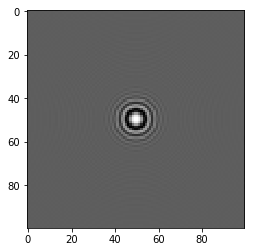

In [7]:
holo1_square = holo1.reshape((grid_size, grid_size))

plt.gray()

plt.imshow(holo1_square)

# Fit with lmfit

In [ ]:
params = None
params = Parameters()
params.add('wavevector', value=2*np.pi/illum_wavelength, min=0, vary=False)
params.add('x', min=0, max=500*pixel_size)
params.add('y', value=150*pixel_size, vary=False)
params.add('z', value=5, vary=False)
params.add('rem', value=1.108, vary=False)
params.add('imm', value=0, vary=False)
params.add('r', value=.5, vary=False)

In [ ]:
out = minimize(residual, params, args=(detector_grid, obs))

In [ ]:
out.params.pretty_print()

In [ ]:
out.chisqr

In [ ]:
fitparams = [out.params[key].value for key in out.params]
infholo = rg_sphere_holo(detector_grid, *fitparams)

In [ ]:
infholo_s = infholo.reshape((grid_size, grid_size))
plt.imshow(infholo_s)

In [ ]:
out.params['x'].value / pixel_size

In [ ]:
detector_grid.shape

# Plot $\chi^2$ surfaces

### x (or y):

In [8]:
rgholo_varycenter = functools.partial(rg_sphere_holo2, position=detector_grid, k=illum_wavenumber, m=_index, a=_radius)

In [9]:
x_vals = np.linspace(0, pixel_size*grid_size, 10*int(grid_size))
centers = math.cartesian(x_vals, 50*pixel_size, 5)
chisq_x = [chisq(holo1, rgholo_varycenter(center=point)) for point in centers]

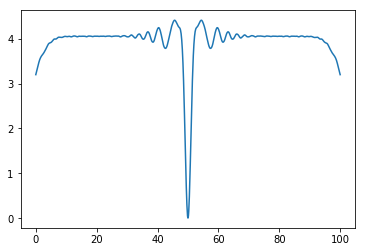

In [10]:
plt.plot(x_vals/pixel_size, chisq_x)
plt.show()

### z:

In [11]:
z_vals = np.linspace(0, 10, 100)
centers = math.cartesian(50*pixel_size, 50*pixel_size, z_vals)
chisq_z = [chisq(holo1, rgholo_varycenter(center=point)) for point in centers]

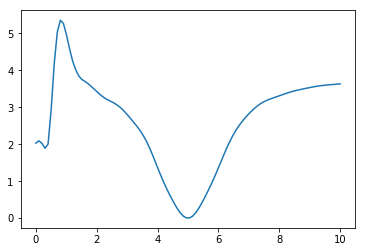

In [12]:
plt.plot(z_vals, chisq_z)
plt.show()

### Radius:

In [13]:
rgholo_varyradius = functools.partial(rg_sphere_holo2, position=detector_grid, k=illum_wavenumber, m=_index, center=_center)

In [14]:
r_vals = np.linspace(illum_wavelength*.1, illum_wavelength*10, 100)
chisq_r = [chisq(holo1, rgholo_varyradius(a=radius)) for radius in r_vals]

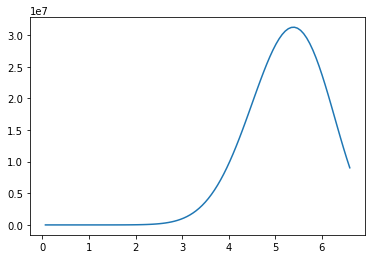

In [15]:
plt.plot(r_vals, chisq_r)
plt.show()

### Real part of m:

In [16]:
rgholo_varyindex = functools.partial(rg_sphere_holo2, position=detector_grid, k=illum_wavenumber, center=_center, a=_radius)

In [17]:
m_vals = np.linspace(1, 2, 100)
m_vals = math.cartesian(m_vals, 0)
chisq_m = [chisq(holo1, rgholo_varyindex(m=index)) for index in m_vals]

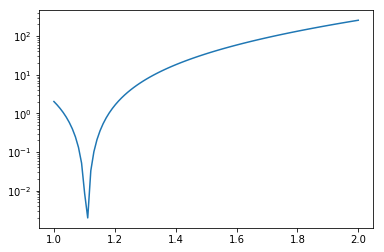

In [18]:
plt.semilogy(m_vals[:,0], chisq_m)
plt.show()